## Importing Data

In this notebook-

1. Data was loaded into pandas
2. Reshaped for transfer learning
3. Defined architecture utilizing weights from Imagenet model
4. Data was input into the model
5. Results evaluated
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import keras
from keras.layers import Dropout
from keras.utils import np_utils

In [2]:
df_sign = pd.read_csv('sign_mnist_train.csv')

In [3]:
df_sign_test = pd.read_csv('sign_mnist_test.csv')

## Setting up train and test sets

In [4]:
scaler = StandardScaler()

In [5]:
X_train = df_sign.iloc[:,1:785]

In [6]:
X_train_scaled= scaler.fit_transform(X_train)


In [7]:
X_train2 = X_train_scaled.reshape((-1,28,28, 1))

In [8]:
X_train2.shape

(27455, 28, 28, 1)

In [9]:
X_train3 = np.repeat(X_train2, 3, axis=-1)

In [10]:
X_train3.shape

(27455, 28, 28, 3)

In [11]:
y_train = df_sign['label']

In [12]:
y_train_cat = np_utils.to_categorical(y_train)

In [13]:
X_train3.shape , y_train_cat.shape

((27455, 28, 28, 3), (27455, 25))

In [14]:
X_test = df_sign_test.iloc[:,1:785]

In [15]:
X_test_scaled= scaler.transform(X_test)


In [16]:
X_test2 = X_test_scaled.reshape((-1,28,28, 1))

In [17]:
X_test3 = np.repeat(X_test2, 3, axis=-1)

In [18]:
y_test = df_sign_test['label']

## Transfer Learning with ImageNet

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer
from keras.applications.vgg16 import VGG16
from keras.layers import ZeroPadding2D, Dropout 

base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Freeze convolutional layers
for layer in base.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=X_train3.shape[1:]),
                         ZeroPadding2D(padding=2),
                         base,
                         Flatten(),
                         Dense(30, activation='relu'),
                         Dense(35, activation='relu'),
                         Dense(25, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [20]:
NN_transfer.fit(X_train3, y_train_cat, epochs=10, verbose=1, validation_split=0.25)

Epoch 1/10
644/644 [==============================] - 148s 212ms/step - loss: 2.2180 - accuracy: 0.3598 - val_loss: 0.7556 - val_accuracy: 0.7700
Epoch 2/10
644/644 [==============================] - 128s 199ms/step - loss: 0.6302 - accuracy: 0.8133 - val_loss: 0.4108 - val_accuracy: 0.8865
Epoch 3/10
644/644 [==============================] - 117s 181ms/step - loss: 0.3622 - accuracy: 0.8975 - val_loss: 0.2731 - val_accuracy: 0.9242
Epoch 4/10
644/644 [==============================] - 136s 212ms/step - loss: 0.2430 - accuracy: 0.9331 - val_loss: 0.2103 - val_accuracy: 0.9432
Epoch 5/10
644/644 [==============================] - 125s 193ms/step - loss: 0.1710 - accuracy: 0.9561 - val_loss: 0.1726 - val_accuracy: 0.9487
Epoch 6/10
644/644 [==============================] - 135s 210ms/step - loss: 0.1378 - accuracy: 0.9628 - val_loss: 0.1323 - val_accuracy: 0.9679
Epoch 7/10
644/644 [==============================] - 140s 218ms/step - loss: 0.1088 - accuracy: 0.9719 - val_loss: 0.1028 -

In [21]:
accuracy_score(y_test, np.argmax(NN_transfer.predict(X_test3), axis=-1))

0.8768823201338539

## Confusion Matrix

In [23]:
y_pred = np.argmax(NN_transfer.predict(X_test3),axis = 1) 

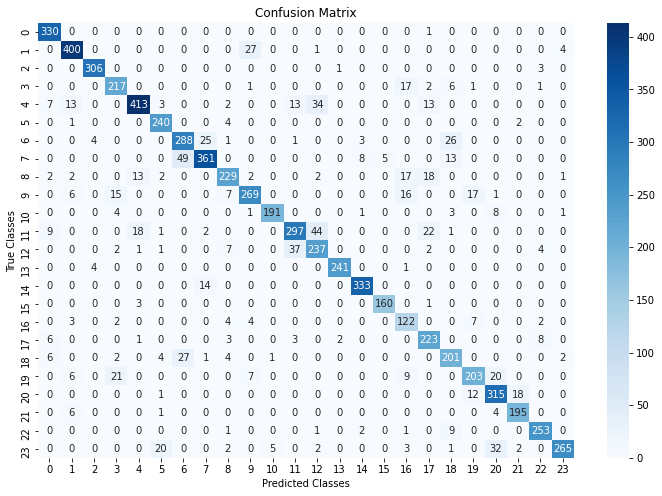

In [24]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12,8))
sns.heatmap(CM, annot=True, cmap="Blues", fmt = 'g')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()